In [ ]:
import os
import random
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd
import ydata_profiling  

plt.style.use('seaborn-v0_8-paper')
current_dir = Path.cwd()
DATASET_ROOT = current_dir.parent.parent / "data" / "noise_dataset" / "musan"
SAMPLE_RATE = 16000

In [9]:
import pandas as pd
import seaborn as sns

def create_musan_inventory(root_path):
    """
    Scans the MUSAN directory recursively to build a metadata DataFrame.
    It extracts the Category and Subcategory from the folder structure.

    Args:
        root_path (Path): The pathlib object pointing to the dataset root.

    Returns:
        pd.DataFrame: A DataFrame containing 'Category', 'Subcategory', and 'Path' columns.
    """
    if not root_path.exists():
        print(f"Path not found: {root_path}")
        return pd.DataFrame()

    files = list(root_path.rglob("*.wav"))
    
    data = []
    for file_path in files:
        relative_path = file_path.relative_to(root_path)
        parts = relative_path.parts
        
        if len(parts) >= 2:
            category = parts[0]
            subcategory = parts[1]
        elif len(parts) == 1:
            category = parts[0]
            subcategory = "generic"
        else:
            category = "unknown"
            subcategory = "unknown"
            
        data.append({
            "Category": category,
            "Subcategory": subcategory,
            "Path": str(file_path)
        })

    df = pd.DataFrame(data)
    
    print(f"Inventory created with {len(df)} files.")
    print("Categories found:", df['Category'].unique())
    
    return df

# Create the dataframe
df_musan = create_musan_inventory(DATASET_ROOT)

# Display first rows
df_musan.head()

Inventory created with 2016 files.
Categories found: ['music' 'noise' 'speech']


,Category,Subcategory,Path
0,music,fma,c:\Users\ASUS\Desktop\Andes\Maestria\ANTI-SPOO...
1,music,fma,c:\Users\ASUS\Desktop\Andes\Maestria\ANTI-SPOO...
2,music,fma,c:\Users\ASUS\Desktop\Andes\Maestria\ANTI-SPOO...
3,music,fma,c:\Users\ASUS\Desktop\Andes\Maestria\ANTI-SPOO...
4,music,fma,c:\Users\ASUS\Desktop\Andes\Maestria\ANTI-SPOO...


In [10]:
def analyze_musan_structure(root_path):
    """
    Traverses the directory structure to identify categories and count wav files.
    
    Args:
        root_path (Path): The pathlib object pointing to the dataset root.
        
    Returns:
        dict: A dictionary containing the file counts per category.
    """
    if not root_path.exists():
        raise FileNotFoundError(f"Path not found: {root_path}")

    wav_files = list(root_path.rglob("*.wav"))
    categories = {}

    for file_path in wav_files:
        category = file_path.parent.parent.name
        if category not in categories:
            categories[category] = []
        categories[category].append(file_path)

    print(f"Total files found: {len(wav_files)}")
    for cat, files in categories.items():
        print(f"Category '{cat}': {len(files)} files")

    return categories

musan_data = analyze_musan_structure(DATASET_ROOT)

Total files found: 2016
Category 'music': 660 files
Category 'noise': 930 files
Category 'speech': 426 files


Sample 1: noise-free-sound-0614.wav


Sample 2: noise-free-sound-0617.wav


Sample 3: noise-free-sound-0051.wav


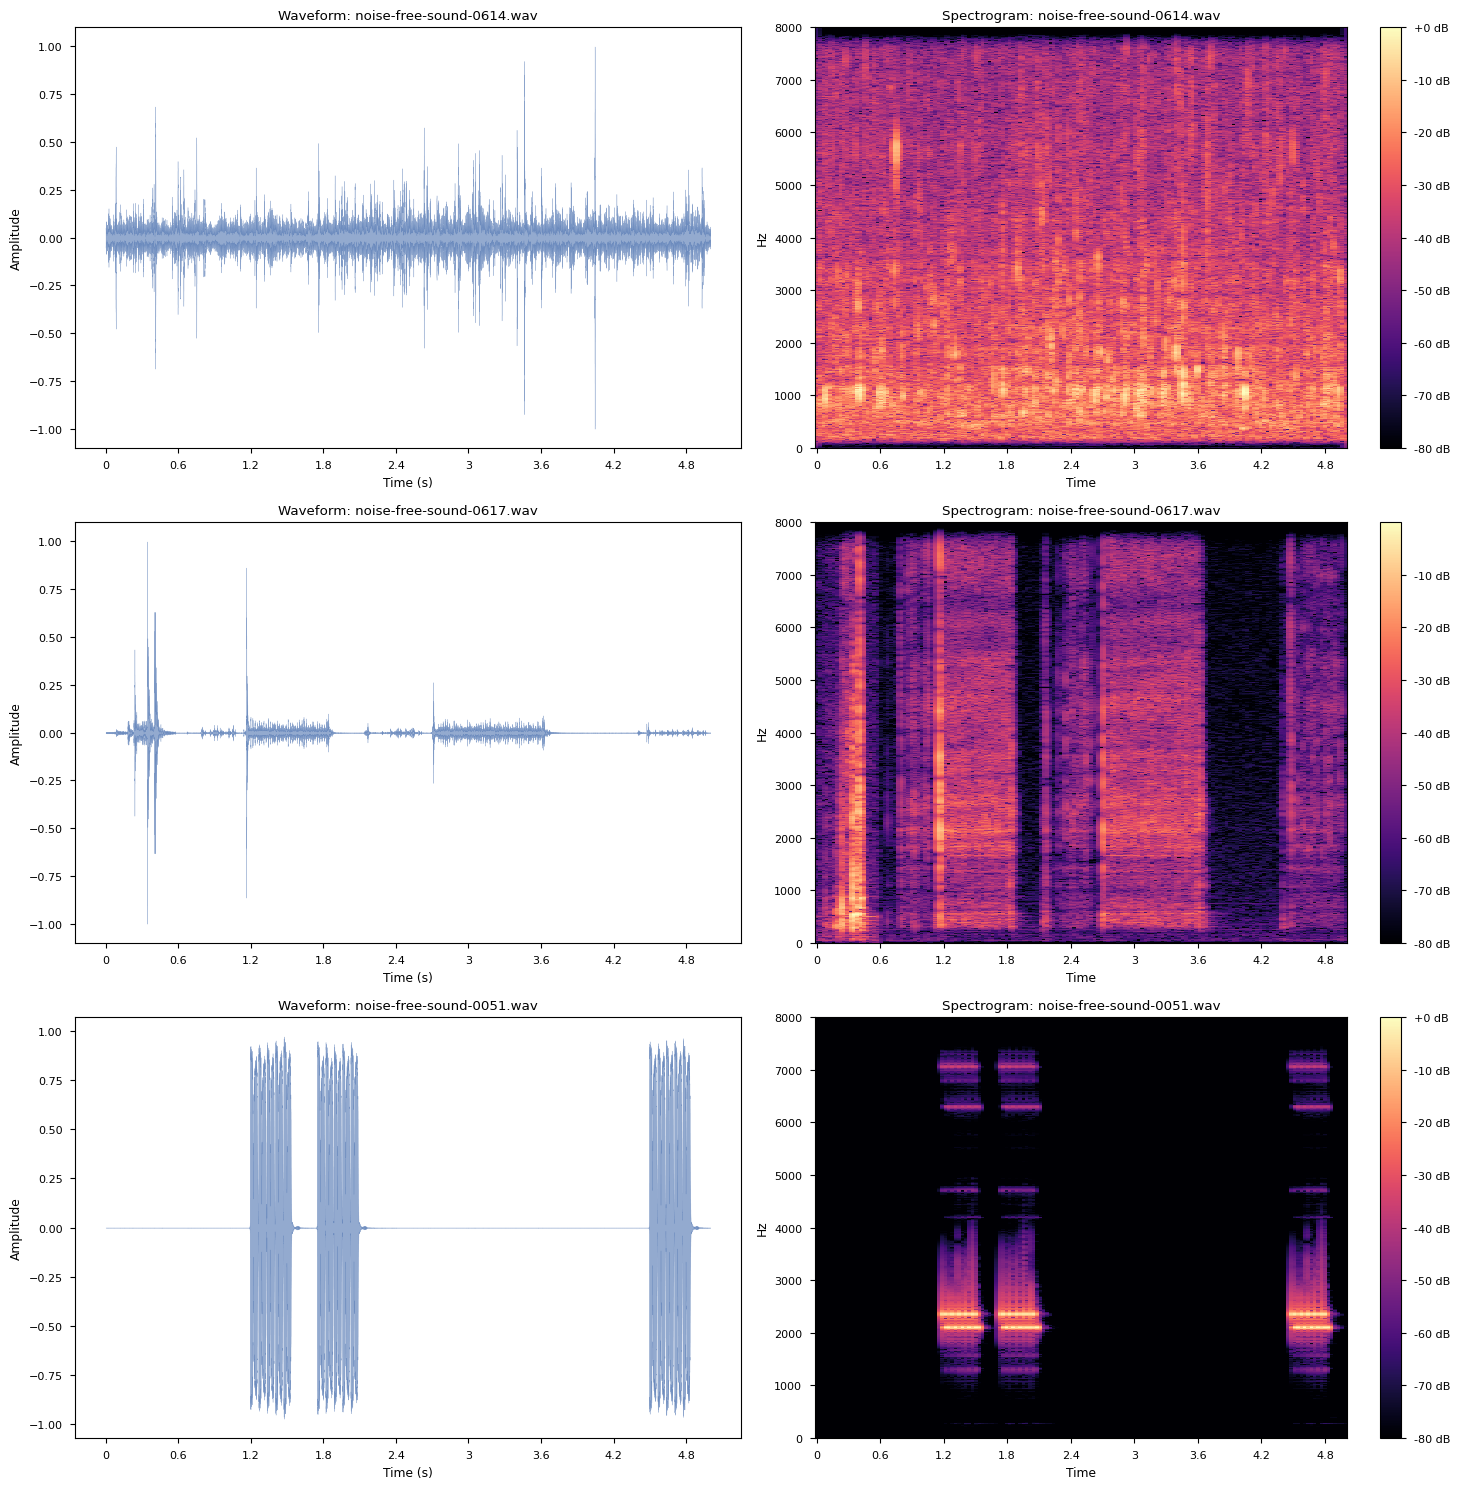

In [11]:
def plot_noise_samples(file_list, num_samples=3):
    """
    Loads random audio files and plots their waveform and spectrogram.
    
    Args:
        file_list (list): List of Path objects to audio files.
        num_samples (int): Number of random samples to visualize.
    """
    if not file_list:
        return

    selected_files = random.sample(file_list, min(num_samples, len(file_list)))
    
    plt.figure(figsize=(15, 5 * num_samples))

    for i, file_path in enumerate(selected_files):
        y, sr = librosa.load(str(file_path), sr=SAMPLE_RATE)
        
        if len(y) > SAMPLE_RATE * 5:
            y = y[:SAMPLE_RATE * 5]

        # Waveform
        plt.subplot(num_samples, 2, 2 * i + 1)
        librosa.display.waveshow(y, sr=sr, alpha=0.6, color='#4C72B0')
        plt.title(f"Waveform: {file_path.name}")
        plt.ylabel("Amplitude")
        plt.xlabel("Time (s)")

        # Spectrogram
        plt.subplot(num_samples, 2, 2 * i + 2)
        D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
        librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='hz')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f"Spectrogram: {file_path.name}")
        plt.ylim(0, 8000)

        print(f"Sample {i+1}: {file_path.name}")
        ipd.display(ipd.Audio(y, rate=sr))

    plt.tight_layout()
    plt.show()

if 'noise' in musan_data:
    plot_noise_samples(musan_data['noise'])
elif 'free-sound' in musan_data:
    plot_noise_samples(musan_data['free-sound'])
else:
    all_files = [f for files in musan_data.values() for f in files]
    plot_noise_samples(all_files)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_87352\3876104822.py:12: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby('Category', group_keys=False).apply(lambda x: x.sample(min(len(x), int(sample_size))))


Calculating durations for 600 files...


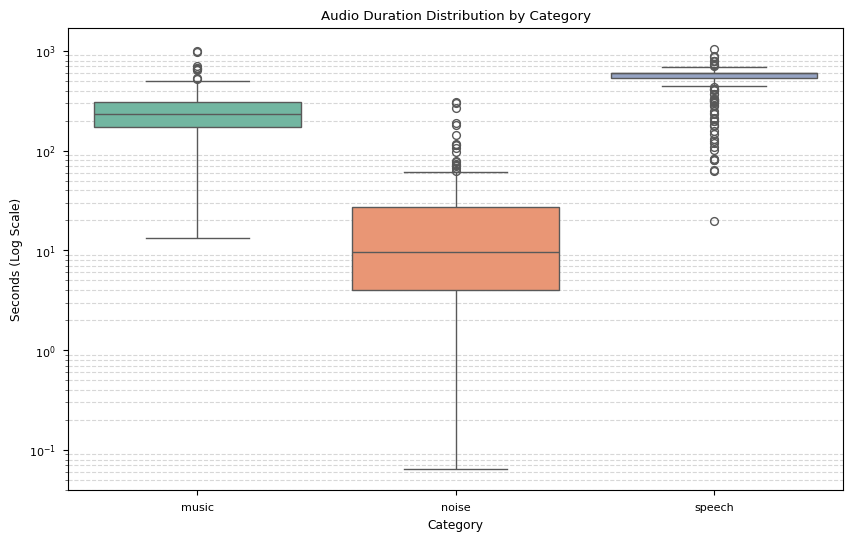


DETAILED DURATION STATISTICS
          Min Duration (s)  Max Duration (s)  Avg Duration (s)  Sample Count
Category                                                                    
music            13.296313        987.036750        258.303584           200
noise             0.064562        306.416313         25.002842           200
speech           19.670250       1047.954313        528.126707           200

GLOBAL DATASET STATISTICS
Shortest Audio: 0.0646 seconds
Longest Audio:  1047.9543 seconds
Average Audio:  270.4777 seconds


In [ ]:
def analyze_duration_stats(df, sample_size=200):
    """
    Calculates and displays detailed duration statistics for the dataset.
    It computes Min, Max, and Average duration per category.
    
    Args:
        df (pd.DataFrame): DataFrame containing file paths and categories.
        sample_size (int): Number of files to sample per category to speed up the process.
    """
    # 1. Sample files to avoid reading the entire dataset (which is slow)
    sampled_df = df.groupby('Category', group_keys=False).apply(lambda x: x.sample(min(len(x), int(sample_size))))
    
    print(f"Calculating durations for {len(sampled_df)} files...")
    
    durations = []
    for _, row in sampled_df.iterrows():
        try:
            duration = librosa.get_duration(path=row["Path"])
            durations.append({
                "Category": row["Category"], 
                "Subcategory": row["Subcategory"],
                "Duration": duration
            })
        except Exception:
            continue
            
    df_durations = pd.DataFrame(durations)
    
    # 2. Visual Boxplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(x="Category", y="Duration", data=df_durations, palette="Set2", hue="Category")
    plt.title("Audio Duration Distribution by Category")
    plt.ylabel("Seconds (Log Scale)")
    plt.yscale('log') # Log scale because music is much longer than noise
    plt.grid(True, which="minor", ls="--", alpha=0.5)
    plt.show()
    
    # 3. Numeric Statistics Table
    # Aggregating min, max, mean, and count
    stats = df_durations.groupby("Category")["Duration"].agg(['min', 'max', 'mean', 'count'])
    
    # Renaming for clarity
    stats = stats.rename(columns={
        'min': 'Min Duration (s)', 
        'max': 'Max Duration (s)', 
        'mean': 'Avg Duration (s)', 
        'count': 'Sample Count'
    })
    
    print("\n" + "="*50)
    print("DETAILED DURATION STATISTICS")
    print("="*50)
    print(stats)
    
    print("\n" + "="*50)
    print("GLOBAL DATASET STATISTICS")
    print("="*50)
    print(f"Shortest Audio: {df_durations['Duration'].min():.4f} seconds")
    print(f"Longest Audio:  {df_durations['Duration'].max():.4f} seconds")
    print(f"Average Audio:  {df_durations['Duration'].mean():.4f} seconds")

# Execute correctly
analyze_duration_stats(df_musan)

In [15]:
def create_musan_metadata_dataframe(root_path: Path) -> pd.DataFrame:
    """
    Scans the MUSAN dataset and builds a comprehensive Pandas DataFrame with metadata.
    This dataset serves as the master index for data augmentation processes.

    Columns:
        - Filename: Name of the audio file.
        - Category: Main category (music, speech, noise).
        - Subcategory: Source collection (fma, free-sound, etc.).
        - Duration: Length of the audio in seconds.
        - Format: Audio file extension (e.g., wav).
        - Path: Absolute path to the file.

    Args:
        root_path (Path): Path object pointing to the MUSAN root directory.

    Returns:
        pd.DataFrame: The structured metadata dataset.
    """
    if not root_path.exists():
        raise FileNotFoundError(f"Root path not found: {root_path}")

    print(f"Scanning {root_path} for audio files...")
    
    wav_files = list(root_path.rglob("*.wav"))
    metadata_list = []

    print(f"Processing metadata for {len(wav_files)} files...")

    for file_path in wav_files:
        try:
            relative_parts = file_path.relative_to(root_path).parts
            
            if len(relative_parts) >= 3:
                category = relative_parts[0]
                subcategory = relative_parts[1]
            elif len(relative_parts) == 2:
                category = relative_parts[0]
                subcategory = "generic"
            else:
                category = "unknown"
                subcategory = "unknown"

            duration = librosa.get_duration(path=file_path)

            metadata_list.append({
                "Filename": file_path.name,
                "Category": category,
                "Subcategory": subcategory,
                "Duration": float(f"{duration:.4f}"),
                "Format": file_path.suffix.replace('.', ''),
                "Path": str(file_path.resolve())
            })
            
        except Exception:
            continue

    df = pd.DataFrame(metadata_list)
    
    # Reorder columns for better readability
    df = df[["Category", "Subcategory", "Filename", "Duration", "Format", "Path"]]
    
    return df

# Build and display
df_musan_master = create_musan_metadata_dataframe(DATASET_ROOT)

print(f"\nDataset Shape: {df_musan_master.shape}")
display(df_musan_master.head())
display(df_musan_master.groupby(['Category', 'Subcategory'])['Duration'].describe())

Scanning c:\Users\ASUS\Desktop\Andes\Maestria\ANTI-SPOOF\data\noise_dataset\musan for audio files...
Processing metadata for 2016 files...

Dataset Shape: (2016, 6)


,Category,Subcategory,Filename,Duration,Format,Path
0,music,fma,music-fma-0000.wav,297.9787,wav,C:\Users\ASUS\Desktop\Andes\Maestria\ANTI-SPOO...
1,music,fma,music-fma-0001.wav,218.0441,wav,C:\Users\ASUS\Desktop\Andes\Maestria\ANTI-SPOO...
2,music,fma,music-fma-0002.wav,249.5478,wav,C:\Users\ASUS\Desktop\Andes\Maestria\ANTI-SPOO...
3,music,fma,music-fma-0003.wav,324.7804,wav,C:\Users\ASUS\Desktop\Andes\Maestria\ANTI-SPOO...
4,music,fma,music-fma-0004.wav,322.2987,wav,C:\Users\ASUS\Desktop\Andes\Maestria\ANTI-SPOO...


count        mean         std      min        25%  \
Category Subcategory                                                          
music    fma              128.0  235.963471   91.522712  48.0650  177.05795   
         fma-western-art   93.0  226.526091  136.711428  21.5249  130.24800   
         hd-classical      75.0  283.634375  197.868566  68.1535  141.47915   
         jamendo          217.0  240.588217   76.726355  41.0120  200.64600   
         rfm              147.0  194.981593  106.305943  13.2963  145.71095   
noise    free-sound       843.0   25.246912   41.663934   0.0261    4.98155   
         sound-bible       87.0   13.006555   15.085893   0.5520    3.06905   
speech   librivox         173.0  424.002039  214.220501  56.2677  252.49960   
         us-gov           253.0  570.208483  107.017736  19.6702  599.92810   

                               50%        75%        max  
Category Subcategory                                      
music    fma              229.4463  270.53710   702.5370  
         fma-western-art  178.6776  333.06120   720.0392  
         hd-classical     221.1004  360.82940   981.6555  
         jamendo          231.4440  284.47300   633.9910  
         rfm              188.0294  226.88655   987.0367  
noise    free-sound        11.9902   29.56675   494.6599  
         sound-bible        6.7499   17.47500    62.6416  
speech   librivox         411.1151  589.97550  1047.9543  
         us-gov           599.9804  600.00650   648.3070

In [17]:
ydata_profiling.ProfileReport(df_musan_master, title="MUSAN Dataset Profiling Report")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00, 33.62it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]